In [1]:
from jrieke import interpretation
from jrieke.utils import load_nifti
import jrieke.models as models
import torch
from innvestigator import InnvestigateModel
from copy import deepcopy
from jrieke import interpretation
import jrieke.utils as utils
import matplotlib.colors as mcolors

from copy import deepcopy
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from settings import settings
from utils import load_data
from nmm_mask_areas import short_name_map
for k in settings.keys():
    print("Adding " + k + " to namespace")
    globals()[k] = settings[k]

Adding model_path to namespace
Adding data_path to namespace
Adding ADNI_DIR to namespace
Adding 1.5T_table to namespace
Adding 1.5T_image_dir to namespace
Adding 3T_table to namespace
Adding 3T_image_dir to namespace
Adding binary_brain_mask to namespace
Adding nmm_mask_path to namespace


In [2]:
data_path = "/analysis/ritter/projects/Methods/LRP/data/rieke-copy1/2Node_trial0/beta0"
mask_path = "/analysis/ritter/projects/Methods/LRP/data/"

In [3]:
model_path = "/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1_OHE/repeat_0_cv_fold_0_BEST_ITERATION.h5"

#### Load results from evaluation notebook

In [4]:
cases = ["AD", "HC", "TP", "TN", "FP", "FN"]

mean_maps_LRP = dict()
mean_maps_GB = dict()
rs_per_area_LRP = dict()
rs_per_area_GB = dict()
for case in cases:
    mean_maps_LRP[case] = load_nifti(os.path.join(data_path, "LRP_{case}.nii".format(case=case)))
    mean_maps_GB[case] = load_nifti(os.path.join(data_path, "GB_{case}.nii".format(case=case)))
    with open(os.path.join(data_path, "LRP_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
        rs_per_area_LRP[case] = pickle.load(file)
    with open(os.path.join(data_path, "GB_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
        rs_per_area_GB[case] = pickle.load(file)

nmm_mask = load_nifti(os.path.join(mask_path, "rescaled_nmm_mask.nii"))
with open(os.path.join(data_path, 'area_sizes.pkl'), 'rb') as file:
    area_sizes = pickle.load(file)
    
ad_score_list = np.loadtxt(os.path.join(data_path, "ad_scores.txt"))

In [5]:
mask_GB = True

In [6]:
# mask out brains for GB
if mask_GB:
    for case in cases:
        mean_maps_GB[case] = mean_maps_GB[case] * nmm_mask

#### Load test dataset for individual brains

In [7]:
import h5py

In [8]:
def min_max_normalization(subset):
    for i in range(len(subset)):
        subset[i] -= np.min(subset[i])
        subset[i] /= np.max(subset[i])
    return subset
    
def load_data(skip_train=True, skip_val=True, skip_test=False, dtype=np.float32):
    """ Load hdf5 files and extract columns. """
    X_train, y_train, X_val, y_val, X_holdout, y_holdout = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    # train
    if not skip_train:
        train_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(193, 229, 193)_reducedValSize.h5", 'r')
        X_train, y_train = train_h5['X'], train_h5['y']
        X_train = np.expand_dims(np.array(X_train, dtype=dtype), 1)
        X_train = min_max_normalization(X_train)
        y_train = np.array(y_train)
        print("Total training set length: {}".format(len(y_train)))
        print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
        print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))
    if not skip_val:
        # val
        val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(193, 229, 193)_reducedValSize.h5", 'r')
        X_val, y_val = val_h5['X'], val_h5['y']
        X_val = np.expand_dims(np.array(X_val, dtype=dtype), 1)
        X_val = min_max_normalization(X_val)
        y_val = np.array(y_val)
        print("Total validation set length: {}".format(len(y_val)))
    if not skip_test:
        # test
        holdout_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(193, 229, 193)_reducedValSize.h5", 'r')
        X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
        X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 1)
        X_holdout = min_max_normalization(X_holdout)
        y_holdout = np.array(y_holdout)
        print("Total test set length: {}".format(len(y_holdout)))
   
    return X_train, y_train, X_val, y_val, X_holdout, y_holdout


In [9]:
X_train, y_train, X_val, y_val, X_holdout, y_holdout = load_data()

Total test set length: 172


# Plotting brain maps

In [10]:
shape = mean_maps_LRP["AD"].shape

### Getting contours for areas

In [11]:
from nmm_mask_areas import all_areas

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_colors = [name for hsv, name in by_hsv]
contour_configs = {name: (mini, maxi, cname) for (name, (mini, maxi)), cname in zip(all_areas.items(), sorted_colors[::2])}
contours = {k:None for k in contour_configs.keys()}
for key, (mini, maxi, col) in contour_configs.items():
    tmp_map = np.zeros_like(nmm_mask)
    tmp_map[np.logical_and(nmm_mask>=mini, nmm_mask<=maxi) ] = 40
    contours[key] = tmp_map


## Plotting functions

In [12]:
def plot_contours(areas, x_idx, y_idx, z_idx, c, fig=None, ax=None):
    
    if not areas:
        return
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))

    for c_ , name in zip(c, areas):

        cmap_area = mcolors.LinearSegmentedColormap.from_list(
            name="colored", colors=[(0,0,0,0), c_], N=100)
        cmap_area_border_b = mcolors.LinearSegmentedColormap.from_list(
            name="black", colors=[(0,0,0,0), "black"], N=100)
        cmap_area_border_w = mcolors.LinearSegmentedColormap.from_list(
            name="white", colors=[(0,0,0,0), "white"], N=100)
        slice_area = contours[name][x_idx, y_idx, z_idx].T
        
        cs_ad = ax.contour(slice_area, [0, 10], cmap=cmap_area_border_b, linewidths=2.5, alpha=1, bordercolors="black")

        cs_ad = ax.contour(slice_area, [0, 10], cmap=cmap_area, linewidths=2, alpha=1, bordercolors="black",
                           
                          label= " ".join(areas))


In [13]:
def plot_idv_brain(heat_map, brain_img, ref_scale, fig=None, ax=None, contour_areas=[],
                  x_idx=slice(0, shape[0]), y_idx=slice(0, shape[1]), z_idx=slice(0, shape[2]),
                  vmin=90, vmax=99.5, set_nan=True, cmap=None, c=None):

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))
    
    img = deepcopy(heat_map)
    if set_nan:
        img[nmm_mask==0]=np.nan
    if cmap is None:
        cmap = mcolors.LinearSegmentedColormap.from_list(name='alphared',
                                                  colors=[(1, 0, 0, 0),
                                                         "darkred", "red", "darkorange", "orange", "yellow"],
                                                  N=5000)
        
    if brain_img is not None:
        ax.imshow(brain[x_idx, y_idx, z_idx].T, cmap="gray",
                 vmin=grey_vmin, vmax=grey_vmax, alpha=.45)

    vmin, vmax = np.percentile(ref_scale, vmin), np.percentile(ref_scale, vmax)
    im = ax.imshow(img[x_idx, y_idx, z_idx].T, cmap=cmap, 
               vmin=vmin, vmax=vmax, interpolation="gaussian")
    
   
    ax.axis('off')    

    plot_contours(contour_areas, x_idx, y_idx, z_idx, fig=fig, ax=ax, c=c)
    plt.gca().invert_yaxis()
    return fig, ax, im


## Individual maps

##### Load model

In [14]:
device = 2
net = models.ClassificationModel3D_2Node()
net.cpu()
net.load_state_dict(torch.load(model_path,
                              map_location='cpu'))
net.eval()
net = torch.nn.Sequential(net, torch.nn.Softmax(dim=1))
inn_model = InnvestigateModel(net, lrp_exponent=1,
                                  method="b-rule",
                                  beta=0, epsilon=1e-6).cpu()
inn_model.eval();


Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.



#### TODO: Fix warning, getting warning for wrong beta.

### Obtaining individual heatmaps

In [15]:
def run_guided_backprop(net, image_tensor):
    return interpretation.guided_backprop(net, image_tensor, cuda=False, verbose=False, apply_softmax=False)

def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=1)

def get_heatmaps(idx):
    image_tensor, label = X_holdout[idx], y_holdout[idx]
    image_tensor = torch.Tensor(np.expand_dims(image_tensor, 0))
    image_tensor_LRP = image_tensor.cpu()
    print("Running GB")
    rel_GB = run_guided_backprop(inn_model, image_tensor_LRP)
    print("Running LRP")
    AD_score, rel_LRP = run_LRP(inn_model, image_tensor_LRP)
    print(label, AD_score)
    return rel_LRP.squeeze().detach().cpu().numpy().squeeze(), rel_GB.squeeze()

In [16]:
patientA, patientB = 2, 169
brain_A, brain_B = X_holdout[patientA][0], X_holdout[patientB][0]
grey_vmin, grey_vmax = np.min([brain_A, brain_B]), np.max([brain_A, brain_B])

LRP_map_patient_A, GB_map_patient_A = get_heatmaps(patientA)
LRP_map_patient_B, GB_map_patient_B = get_heatmaps(patientB)


Running GB
Running LRP
1 tensor([[0.0001, 0.9999]])
Running GB
Running LRP
1 tensor([[0.0179, 0.9821]])


##### Define brain slices

In [17]:
first_slice= 57
first_areas = ["Hippocampus", "Temporal pole",
               "Amygdala", "MTG", "Parahippocampal gyrus"]
second_slice= 66
second_areas = first_areas
third_slice= 88
third_areas = ["MTG", "STG", "Frontal pole", "TrIFG"]

# Colors for areas slice 1 & 2
cs = ["linen", "blue", "cyan", "lime", "hotpink"]
# Colors for slice 3
cs_3 = ["grey", "black", "white", "lime"]

# Plotting

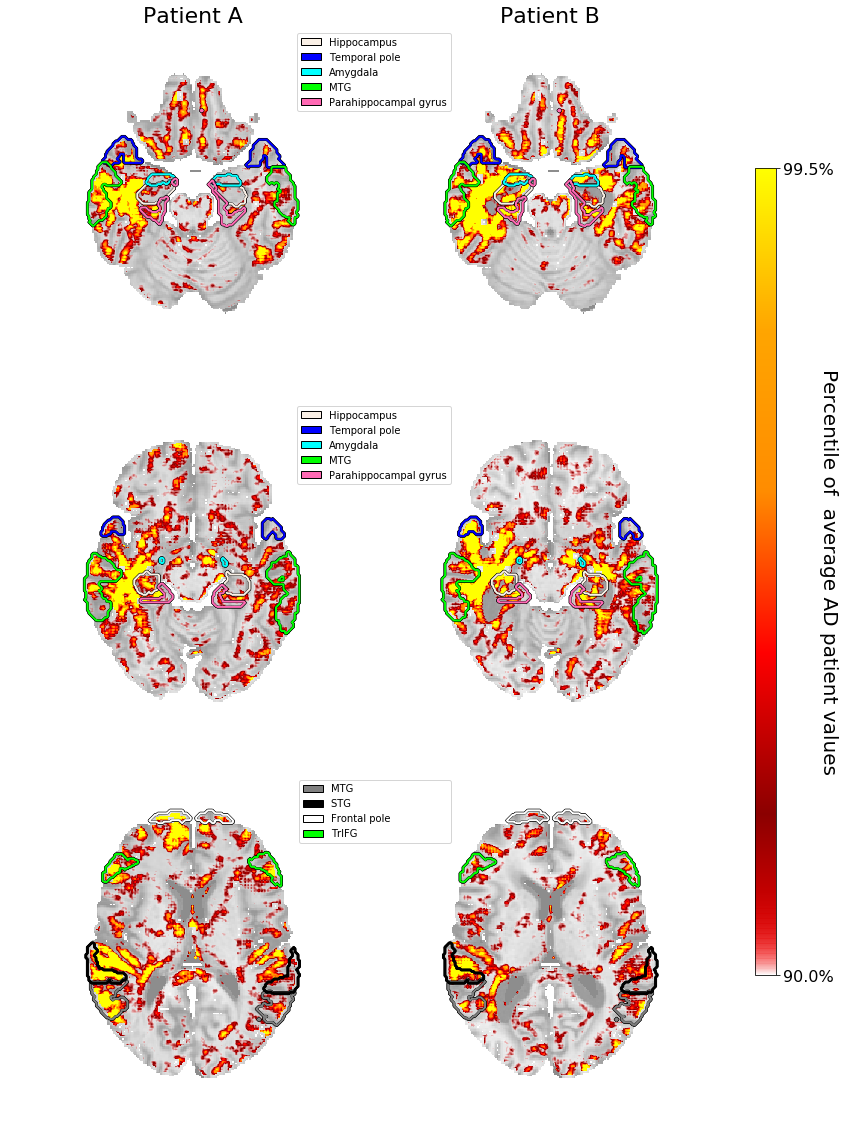

In [20]:
brain = deepcopy(brain_A)
brain[nmm_mask==0] = np.nan
vmin, vmax = 90, 99.5
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(12, 16), sharey=True)

fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=first_slice, 
                              contour_areas=first_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax1[1],
                             c=cs);
ax.set_title("Patient B", fontsize=22)
ax.set_ylabel("Slice number " + str(first_slice))

legend_pics = [plt.Rectangle((0,0),.5,.5,fc = pc, edgecolor="black", linewidth=1) 
    for pc in cs]

ax.legend(legend_pics, first_areas, bbox_to_anchor=[.175, 1, 0, 0], fontsize=10)

fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=second_slice, 
                              contour_areas=second_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax2[1],
                             c=cs);
ax.set_ylabel("Slice number " + str(second_slice))


ax.legend(legend_pics, second_areas, bbox_to_anchor=[.175, 1, 0, 0], fontsize=10)


fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=third_slice, 
                              contour_areas=third_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax3[1],
                             c=cs_3);
ax.set_ylabel("Slice number " + str(third_slice))

legend_pics = [plt.Rectangle((0,0),.5,.5,fc = pc, edgecolor="black", linewidth=1) 
    for pc in cs_3]

ax.legend(legend_pics, ["{s:<30}".format(s=s) for s in third_areas], bbox_to_anchor=[.175, 1, 0, 0], fontsize=10)


brain = deepcopy(brain_B)
brain[nmm_mask==0] = np.nan


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=first_slice, 
                              contour_areas=first_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax1[0],
                             c=cs);
ax.set_title("Patient A", fontsize=22)

ax.set_ylabel("Slice number " + str(first_slice))


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=second_slice, 
                              contour_areas=second_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax2[0],
                             c=cs);

ax.set_ylabel("Slice number " + str(second_slice))


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=third_slice, 
                              contour_areas=third_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax3[0],
                             c=cs_3);

ax.set_ylabel("Slice number " + str(third_slice))


fig.tight_layout()
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)
vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)], fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "patient_brains.pdf"))

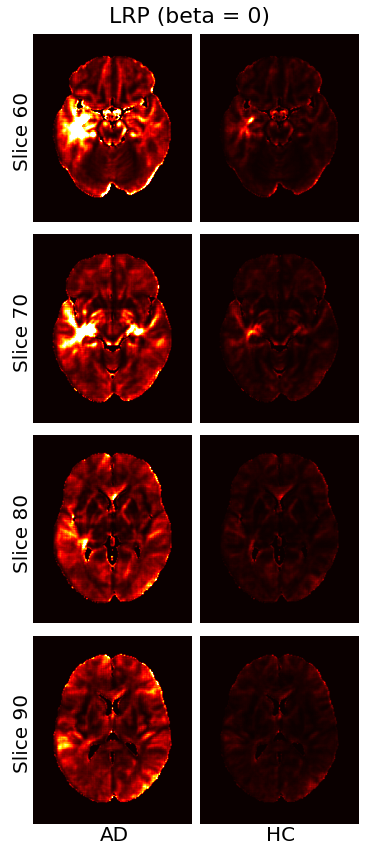

In [72]:
fig, axes = plt.subplots(4, 2, figsize=(6, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=20)

    fig, ax, im = plot_idv_brain(mean_maps_LRP["AD"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(80, -20, "AD", fontsize=20)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):

    fig, ax, im = plot_idv_brain(mean_maps_LRP["HC"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(80, -20, "HC", fontsize=20)
    
fig.tight_layout()
fig.subplots_adjust(right=0.8, top=0.95, hspace=0.05, wspace=0.05)
fig.suptitle("LRP (beta = 0)", fontsize=22, x=.41)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)


vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                       fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "LRP_AD_HC_brain.pdf"), bbox_inches='tight')


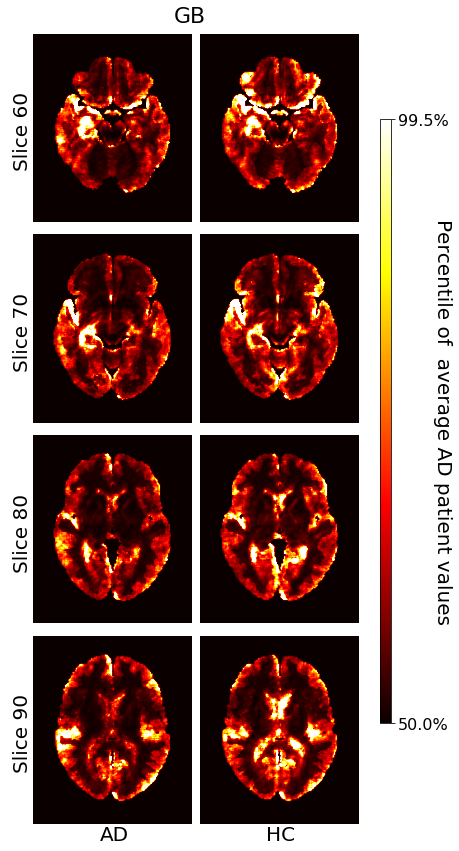

In [73]:
fig, axes = plt.subplots(4, 2, figsize=(6, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=20)

    fig, ax, im = plot_idv_brain(mean_maps_GB["AD"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(80, -20, "AD", fontsize=20)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):

    fig, ax, im = plot_idv_brain(mean_maps_GB["HC"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(80, -20, "HC", fontsize=20)
    
fig.tight_layout()
fig.subplots_adjust(right=0.8, top=0.95, hspace=0.05, wspace=0.05)
fig.suptitle("GB", fontsize=22, x=.41)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)


vmin_val, vmax_val = np.percentile(mean_maps_GB["AD"], vmin), np.percentile(mean_maps_GB["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                       fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "GB_AD_HC_brain.pdf"), bbox_inches='tight')


In [42]:
import matplotlib as mpl

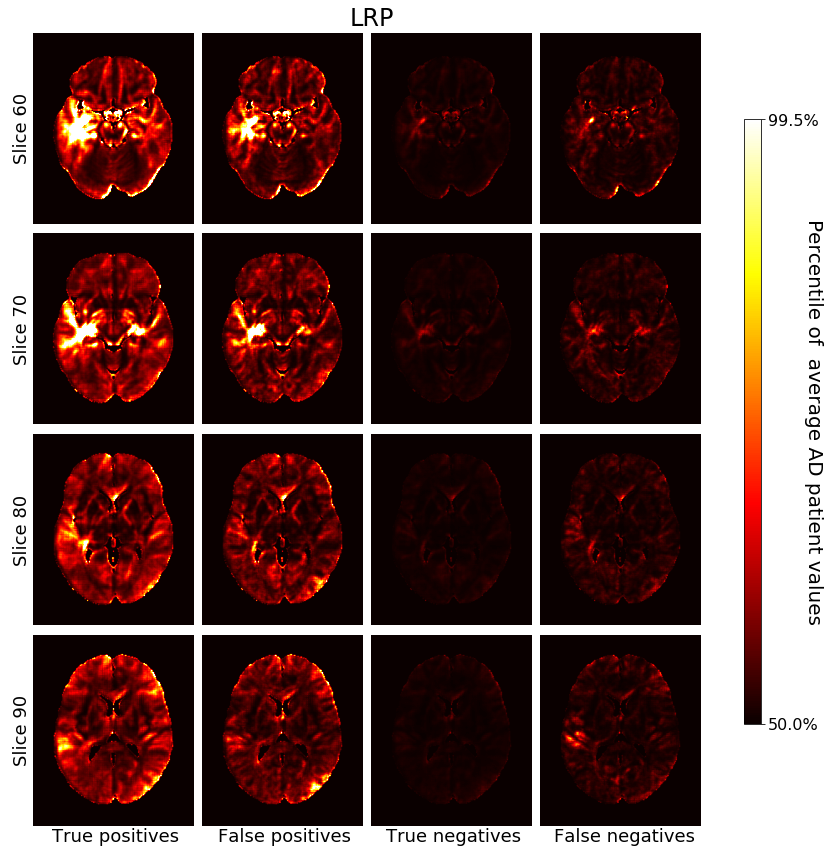

In [70]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=18)
    
    fig, ax, im = plot_idv_brain(mean_maps_LRP["TP"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(22, -20, "True positives", fontsize=18)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["FP"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(18, -20, "False positives", fontsize=18)

for ax, idx in zip(axes[:, 2], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["TN"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(18, -20, "True negatives", fontsize=18)

for ax, idx in zip(axes[:, 3], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["FN"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(16, -20, "False negatives", fontsize=18)

fig.suptitle("LRP", fontsize=24, x=.42)
fig.tight_layout()

fig.subplots_adjust(top=0.95, right=0.8, hspace=0.05, wspace=0.05)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)

vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                        fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "LRP_TP_FP_TN_FN_brain.pdf"))


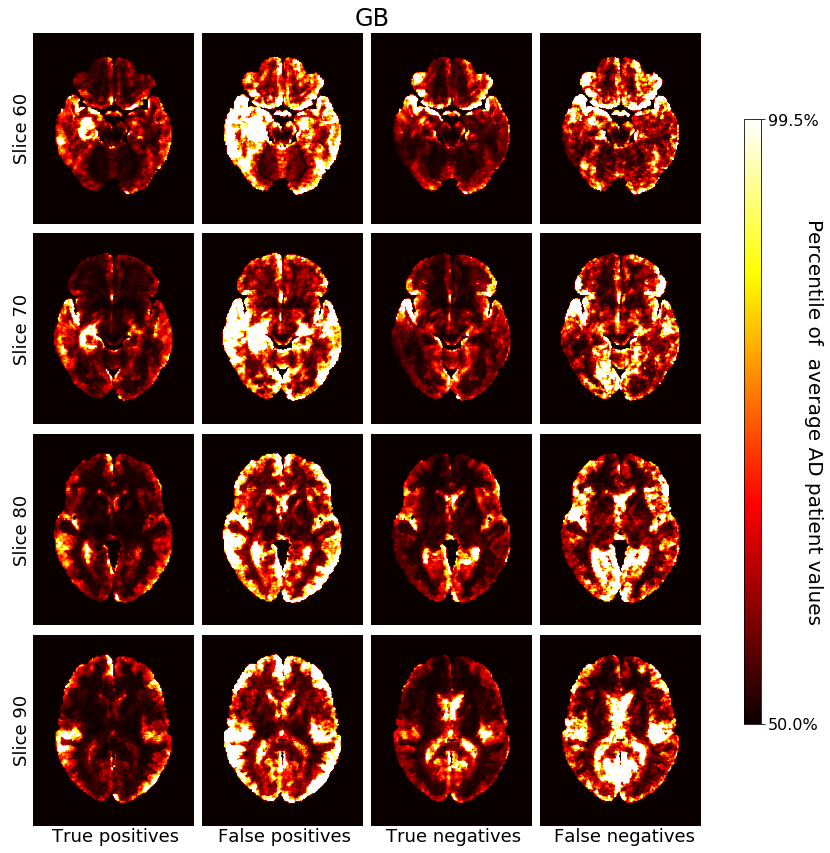

In [71]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=18)
    
    fig, ax, im = plot_idv_brain(mean_maps_GB["TP"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(22, -20, "True positives", fontsize=18)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_GB["FP"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(18, -20, "False positives", fontsize=18)

for ax, idx in zip(axes[:, 2], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_GB["TN"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(18, -20, "True negatives", fontsize=18)

for ax, idx in zip(axes[:, 3], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_GB["FN"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(16, -20, "False negatives", fontsize=18)

fig.suptitle("GB", fontsize=24, x=.42)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

fig.subplots_adjust(top=0.95, right=0.8, hspace=0.05, wspace=0.05)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)

vmin_val, vmax_val = np.percentile(mean_maps_GB["AD"], vmin), np.percentile(mean_maps_GB["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                        fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "GB_TP_FP_TN_FN_brain.pdf"))
